# Part 2c : Building the modular network

### Overview

This Notebook continues where Part 2 left. We work with the original paper once again, but this rebuilding the modular network.

This Notebook builds the network in a more efficient way.

### Chapters


### 0. Plot configuration


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (12, 7)


## 1. Building the network


In [3]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)


Apr 24 14:41:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


### 1b. Building the modular network


What we now want to do is to take the same number of _total_ neurons as before, but change their topology by rewiring connections. Something like the follow figure:

<img src="./../img/neural_columns.png" width="600">

The paper uses a recursive method for splitting the random network into submodules, where

- inhibitory synapses are always rewired within the module
- excitatory synapses are rewired within with the probability $R_{ex}$,

The paper also provides a formula for computing inter-modular connection probabilities:

Splitting a module into $m$ submodules of equal size at each level, the connection density between the modules of the $i$ th level is:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e006.gif" width="500">

where $i = 1,…,l$, if a network is rewiring into a l-level HMN. The connection density within each unit of the network, that is, the l-level module, is

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e007.gif" width="500">


In [4]:
import seaborn as sns
from matplotlib.colors import LogNorm
import pandas as pd



def generate_connection_density(submodule_dict):
    connection_density = {i + 1: [] for i, _ in enumerate(submodule_dict)}
    for source_idx, source_nodes in submodule_dict.items():
        print("Source node:", source_idx)
        for target_idx, target_nodes in submodule_dict.items():
            if source_idx > target_idx:
                continue
            print(target_idx, end=" ")

            n_connections = len(nest.GetConnections(source_nodes, target_nodes))
            n_connections_possible = len(source_nodes) * len(target_nodes)
            connection_density[source_idx] += [n_connections / n_connections_possible]
            connection_density[target_idx] += [n_connections / n_connections_possible]

    return pd.DataFrame(connection_density).iloc[::-1]


def plot_connection_density(submodule_dict):
    connection_density = generate_connection_density(submodule_dict)
    sns.heatmap(connection_density, norm=LogNorm(), cmap="rocket")

## 2. Configure input stimulations


Papers on criticality uses different types of stimulations. Here, we'll use two types of stimulation:

1. All-but-sharp: All modules, one node, continous stimulation.
2. Few-but-wide: Few modules, most nodes, continous stimulation.

TODO

3. Resolve chaos: Spark the network with 180 Hz for 50 ms.


In [5]:
import numpy as np

len_submodule = 625
expected_global_spike_rate = 50


def get_all_but_sharp_stimulation(stop=10_000, rate_hz=8):
    """
    1. Stimulate all modules, but only 25 neurons per module.
    """
    print("All but sharp, Hz =", rate_hz)

    all_but_sharp_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": np.arange(1, 17),
        "stimulate_module_ratio": 0.04,
    }
    return all_but_sharp_stimulation


def get_few_but_wide_stimulation(stop=10_000, rate_hz=4):
    """
    2. Stimulate 4 modules, but stimulate 50% of the neurons.
    """
    print("Few but wide, Hz =", rate_hz)

    all_submodule_ids = np.arange(1, 17)
    size = 4
    modules_to_stimulate = np.random.choice(all_submodule_ids, size=size, replace=False)
    print(f"Stimulating module ids:, {modules_to_stimulate}")

    few_but_wide_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": modules_to_stimulate,
        "stimulate_module_ratio": 0.5,
    }
    return few_but_wide_stimulation

## 3. Run experiments


### 3.1 Replicate the original HMN paper activity


Let's now explore this parameter space of synaptic weights, notice that our parameters are x10 the values on the graph:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g002.jpg" width="600">


source_nodes -> target_nodes : strength 10

separated_sources : strength?

In [5]:
""" from classes.hmn_network import HMN_network

hmm_network_1 = HMN_network()

hmm_network_1.plot_connection_density() """

' from classes.hmn_network import HMN_network\n\nhmm_network_1 = HMN_network()\n\nhmm_network_1.plot_connection_density() '

Few but wide, Hz = 2
Stimulating module ids:, [ 4 13 14  1]
Using static synapses.
Generating submodules of size 625, total network size 10000

Apr 24 14:31:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Base network configured
Network fully built.

Apr 24 14:31:32 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 2000, 'stop': 200}, 'stimulate_module_ids': array([ 4, 13, 14,  1]), 'stimulate_module_ratio': 0.5}

Apr 24 14:31:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 24 14:31:39 SimulationManager::run [Info]: 
    Simulation finished.


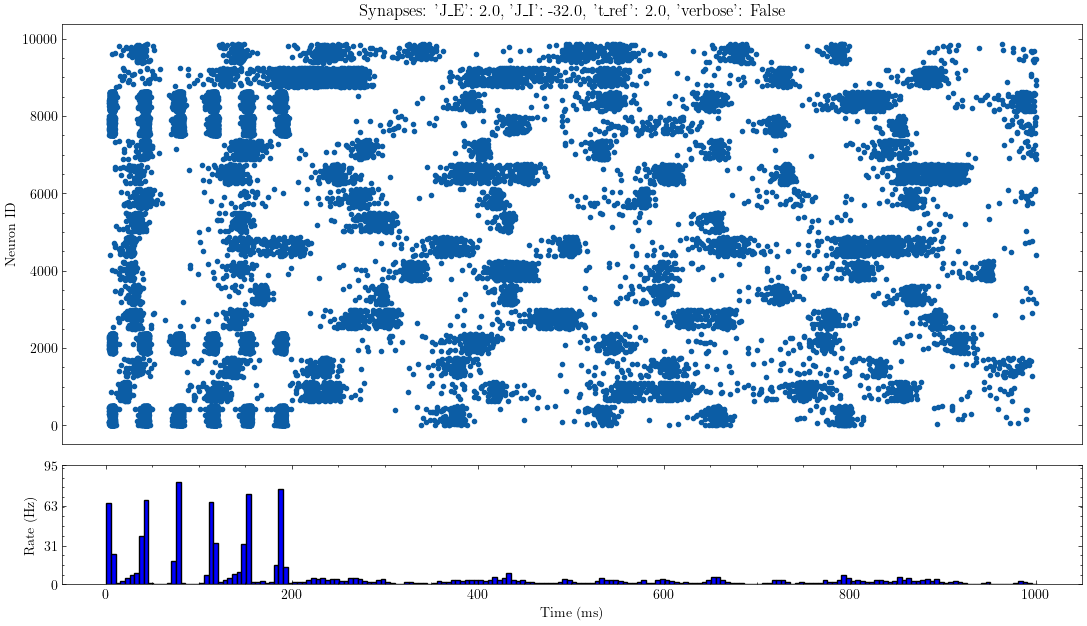

In [11]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

# STIMULATION_SCHEME = get_all_but_sharp_stimulation(stop=200, rate_hz=2)
STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200, rate_hz=2)

#####################
strength = 4


params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "t_ref": 2.0,
    "verbose": False,
}
noise_config = {
    # "module_ids": [2, 6, 11, 15],
    "module_ids": list(range(1, 17, 1)),
    "p": 0.5,
    # "stop": 200.0,
}

simtime = 1_000

hmm_network_1 = HMN_network(**params_1)
hmm_network_1.build()
hmm_network_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
    noise_config=noise_config,
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_1.plot(title=f"Synapses: {params_1}")

**Compute gamma criticality**

The critical exponent of avalanche shapes: $\gamma = \frac{m_{period} - 1}{m_{activity} - 1} $


In [1]:
from classes.criticality_metrics import (
    plot_silent_period_distribution,
    plot_avalanche_sizes_distribution,
    fit_avalanche_sizes_to_power_distribution,
    fit_silent_period_to_power_distribution,
    fit_avalanche_duration_to_power_distribution,
    compute_gamma,
)

spikes_E = hmm_network_1.spikes_E
spike_events = spikes_E.get("events")
df_spike_events = pd.DataFrame(spike_events)

# plot_silent_period_distribution(spike_events)
# plot_avalanche_sizes_distribution(spike_events)

c_length, m_length = fit_silent_period_to_power_distribution(
    [df_spike_events],
)
print()
c_activity, m_size = fit_avalanche_sizes_to_power_distribution(
    [df_spike_events], silent_threshold=0.2
)
print()
c_activity, m_duration = fit_avalanche_duration_to_power_distribution(
    [df_spike_events], silent_threshold=0.2
)


gamma = compute_gamma(m_duration=m_duration, m_size=m_size)

print(f"\nGamma: {gamma}")

NameError: name 'hmm_network_1' is not defined

### 3.2 Adding adaptive inhibitory synapses


All but sharp, Hz = 1
Using static synapses.
Using aeif_cond_exp-model for inhibitory neurons
Generating submodules of size 625, total network size 10000

Apr 24 14:38:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Base network configured
Network fully built.

Apr 24 14:38:48 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 1000, 'stop': 100}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.04}

Apr 24 14:38:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 24 14:38:57 SimulationManager::run [Info]: 
    Simulation finished.


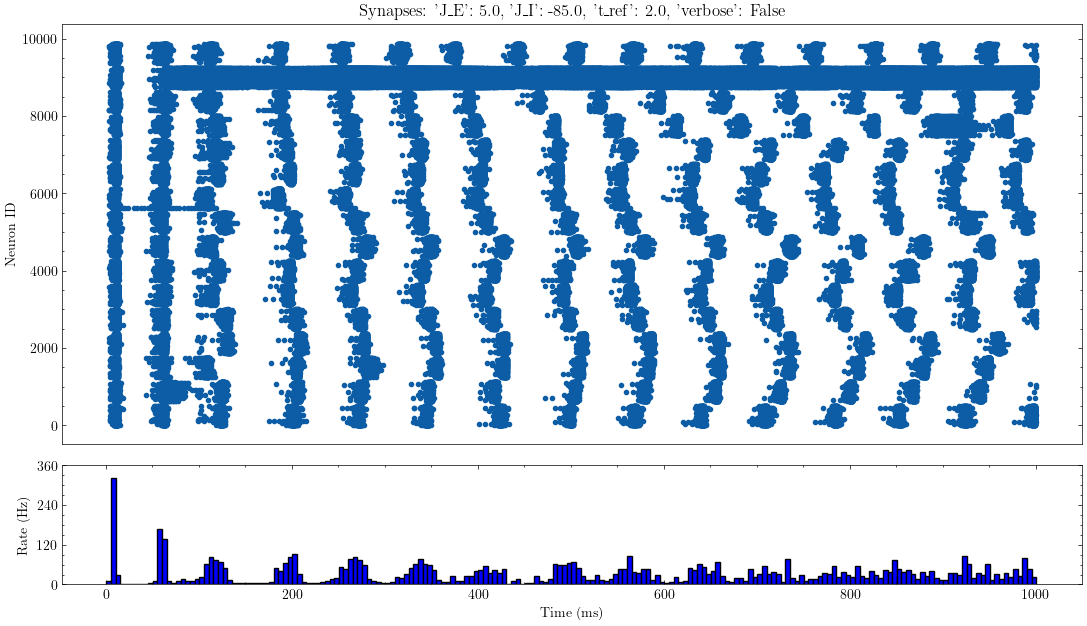

In [22]:
from classes.hmn_adaptive import HMNAdaptive

nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation(stop=100, rate_hz=1)
# STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200, rate_hz=5)

#####################
strength = 10


params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.5 * strength,
    "t_ref": 2.0,
    "verbose": False,
}
noise_config = {
    # "module_ids": [2, 6, 11, 15],
    "module_ids": list(range(1, 17, 1)),
    "p": 0.0,
}

simtime = 1_000

hmm_network_2 = HMNAdaptive(**params_1)
hmm_network_2.build()
hmm_network_2.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
    noise_config=noise_config,
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_2.plot(title=f"Synapses: {params_1}")

### 3.3 Adding short-term depressive inhibitory synapses

All but sharp, Hz = 2
Using depressing synapses.
Generating submodules of size 625, total network size 10000

Apr 24 14:39:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Base network configured
Network fully built.
Stimulation scheme: {'poisson_config': {'rate': 2000, 'stop': 100}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.04}

Apr 24 14:39:33 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.

Apr 24 14:39:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 24 14:39:49 SimulationManager::run [Info]: 
    Simulation finished.


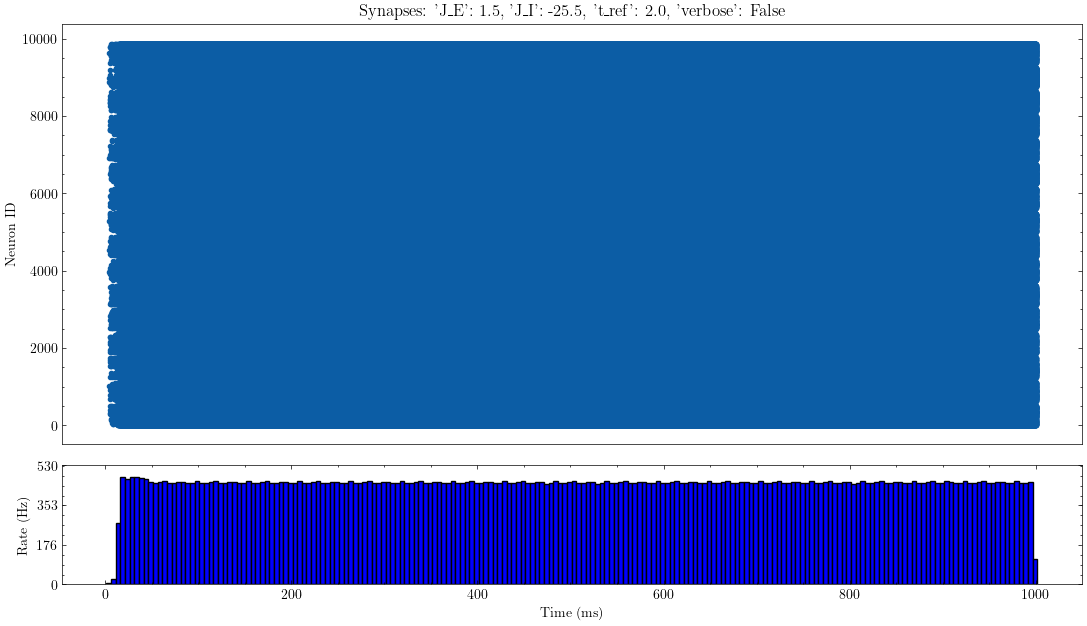

In [23]:
from kex_project.classes.hmn_depressive import HMNDepressive

nest.ResetKernel()
STIMULATION_SCHEME = get_all_but_sharp_stimulation(stop=100, rate_hz=2)
# STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200, rate_hz=5)

#####################
strength = 3


params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.5 * strength,
    "t_ref": 2.0,
    "verbose": False,
}
noise_config = {
    # "module_ids": [2, 6, 11, 15],
    "module_ids": list(range(1, 17, 2)),
    "p": 0.2,
}

simtime = 1_000

hmm_network_3 = HMNDepressive(**params_1)
hmm_network_3.build()
hmm_network_3.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
    noise_config=noise_config,
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_3.plot(title=f"Synapses: {params_1}")

### 3.4 Add [1] short-term depressive inhibitory synapses and [2] adaptive inhibitory neurons

All but sharp, Hz = 5
Using depressing synapses.

Apr 24 14:41:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Using aeif_cond_exp-model for inhibitory neurons
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 24 14:41:27 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 5000, 'stop': 1000}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.04}

Apr 24 14:41:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 2000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 24 14:42:26 SimulationManager::run [Info]: 
    Simulation finished.


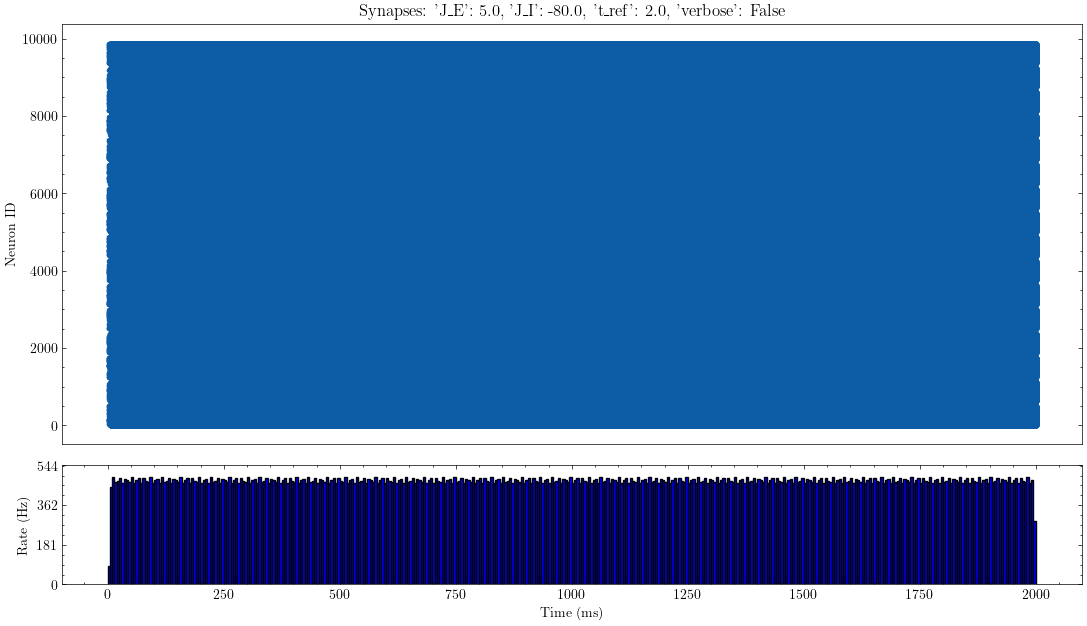

In [6]:
from classes.hmn_depressive_adaptive import HMNDepressiveAdaptive


nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation(stop=1000, rate_hz=5)
# STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200, rate_hz=5)

#####################
strength = 10


params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "t_ref": 2.0,
    "verbose": False,
}
noise_config = {
    # "module_ids": [2, 6, 11, 15],
    "module_ids": list(range(1, 17, 2)),
    "p": 0.0,
}

simtime = 2_000

hmm_network_4 = HMNDepressiveAdaptive(**params_1)
hmm_network_4.build()
hmm_network_4.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
    noise_config=noise_config,
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_4.plot(title=f"Synapses: {params_1}")

Text(0.5, 1.0, 'Histogram of inhibitory synaptic weights')

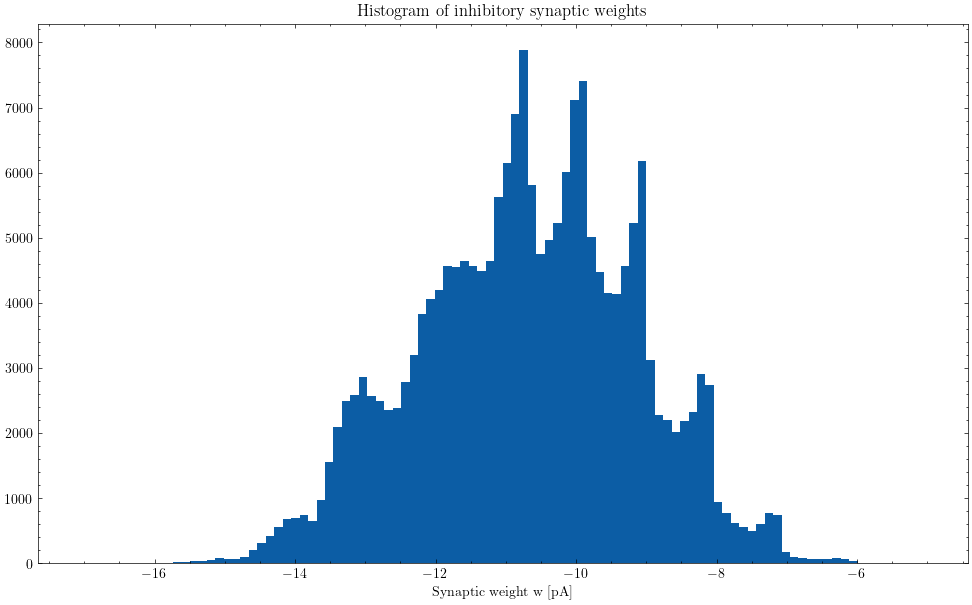

In [ ]:
import pylab

nodes = hmm_network_dep_1.nodes

w = nest.GetStatus(
    nest.GetConnections(nodes[:10_000], synapse_model="inhibitory_synapse"),
    "weight",
)

# pylab.subplot(122)
_ = pylab.hist(w, bins=100)
pylab.xlabel("Synaptic weight w [pA]")
pylab.title("Histogram of inhibitory synaptic weights")

Using depressing synapses.

Apr 08 01:05:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 08 01:05:42 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 1000, 'stop': 10000}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.01}

Apr 08 01:05:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 6000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 08 01:07:03 SimulationManager::run [Info]: 
    Simulation finished.


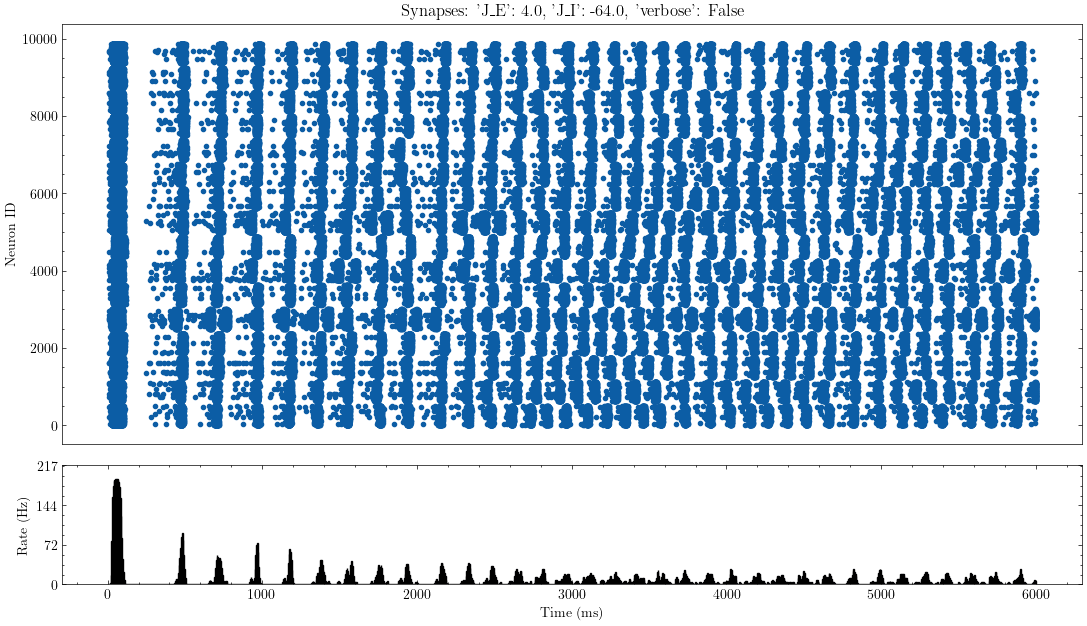

In [ ]:
from kex_project.classes.hmn_depressive import HMNDepressiveNetwork

nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation(rate_hz=1)

#####################
strength = 8

params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 6_000

hmm_network_dep_1 = HMNDepressiveNetwork(**params_1)
hmm_network_dep_1.build()
hmm_network_dep_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_dep_1.plot(title=f"Synapses: {params_1}")